## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Finding the chessboard corners
Using a slightly modified version of the code given in the course video. I plot all the calibration images with the chessboard corners (if found) drawn on top.

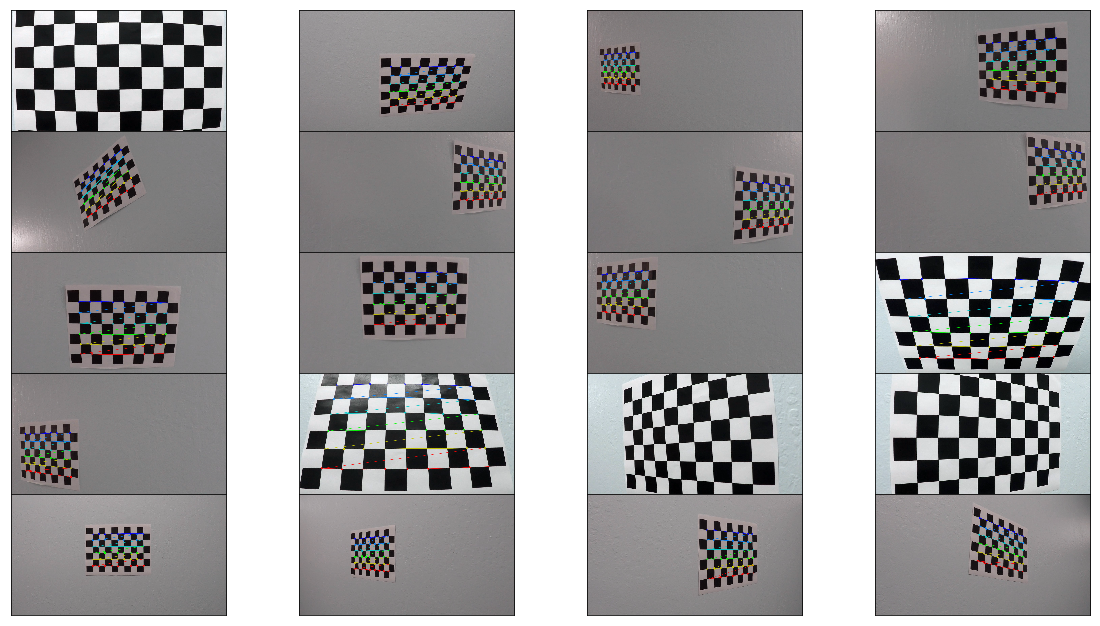

In [58]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(16, 9))
fig.tight_layout()
plt.subplots_adjust(left=0, right=1, wspace=0, hspace=0)
axes = axes.flatten()

# Step through the list and search for chessboard corners
for fname, axis in zip(images, axes):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    axis.imshow(img)
    axis.set_xticks([])
    axis.set_yticks([])

It seems findChessboardCorners() did not find the corners in images 1, 15 and 16, probably because not all of the 9x6 corners were visible in those images. 

### Calculating the camera calibration

In [59]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Lets check the distortion correction with the above images where find the corners failed.

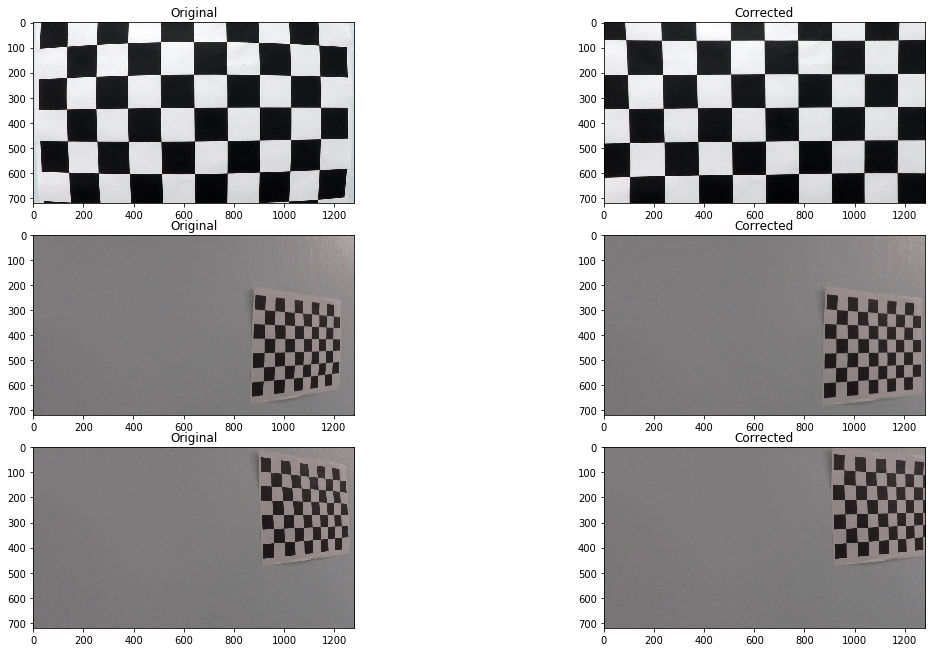

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(16, 9))
fig.tight_layout()

for n, (ax1, ax2) in zip([1, 15, 16], axes):
    fname = 'camera_cal/calibration{}.jpg'.format(n)
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax1.imshow(img)
    ax1.set_title('Original')
    ax2.imshow(dst)
    ax2.set_title('Corrected')

The distorion correction does not look too bad, I think it is ok to proceed.